In [1]:
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from astropy import units as u
from astropy.io import fits
from astropy.visualization import simple_norm
from photutils import EllipticalAperture, CircularAnnulus
from skimage import transform as T
import galsim

# from asymmetry import get_asymmetry
from galaxy_generator import gen_image, gen_galaxy, petrosian_sersic, create_clumps, add_source_to_image, sky_noise, petrosian_sersic
from asymmetry import get_asymmetry, get_residual

/tmp/ipykernel_686/622211292.py:10: DeprecationWarning: `photutils.EllipticalAperture` is a deprecated alias for `photutils.aperture.EllipticalAperture` and will be removed in the future. Instead, please use `from photutils.aperture import EllipticalAperture` to silence this warning.
  from photutils import EllipticalAperture, CircularAnnulus
/tmp/ipykernel_686/622211292.py:10: DeprecationWarning: `photutils.CircularAnnulus` is a deprecated alias for `photutils.aperture.CircularAnnulus` and will be removed in the future. Instead, please use `from photutils.aperture import CircularAnnulus` to silence this warning.
  from photutils import EllipticalAperture, CircularAnnulus


In [2]:
plt.rcParams['font.size'] = 9
plt.rcParams['axes.xmargin'] = .05  # x margin.  See `axes.Axes.margins`
plt.rcParams['axes.ymargin'] = .05  # y margin.  See `axes.Axes.margins`

In [3]:
def plot_setup(xlabel='None'):
    fig = plt.figure(figsize=(6.7, 2.7))
    gs  = fig.add_gridspec(2, 5, wspace=0.05, hspace=0.01)
    ax11 = fig.add_subplot(gs[0,0:3])
    ax12 = fig.add_subplot(gs[0,3])
    ax13 = fig.add_subplot(gs[0,4])
    ax21 = fig.add_subplot(gs[1,0:3], sharex=ax11)
    ax22 = fig.add_subplot(gs[1,3])
    ax23 = fig.add_subplot(gs[1,4])
    
    ax11.tick_params(bottom=False, labelbottom=False)
    ax21.set_xlabel(xlabel); 
    ax11.set_ylabel('A (absolute)');
    ax21.set_ylabel('10x A (squared)');
    
    for ax in [ax12, ax13, ax22, ax23]:
        ax.axis('off')
        
    ax12.set_title('Image')
    ax13.set_title('Residual')
    return np.array([[ax11, ax12, ax13], [ax21, ax22, ax23]])

In [4]:

def get_realistic_galaxy_OLD(image, galaxy, r_pet, mag, sky_mag=23.7,  psf_fwhm=1.32, pxscale=0.396,
               n_clumps=10, clump_properties=None, random_clump_properties=None, rms_noise=True):

    # generate all the clumps and their positions
    clumps, all_xi, all_yi = create_clumps(image, r_pet, n_clumps, mag, telescope_params, transmission_params, bandpass,
                                           clump_properties, random_clump_properties)

    # convolve sources with psf and add to image
    image_psf = add_source_to_image_OLD(image, galaxy, clumps, all_xi, all_yi, psf_fwhm)
  
    if sky_mag:
        # add Poisson noise to image based on pixel counts with added sky level
        image_noise = sky_noise_OLD(image_psf, sky_mag, pxscale, telescope_params, transmission_params, bandpass, rms_noise=rms_noise)[0]
    else:
        image_noise = image_psf
    # FINAL IMAGE IN ELECTRON COUNTS
    return image_noise.array

In [5]:
def get_perfect_galaxy(mag, r_eff, fov_reff=10, pxscale=0.396, sersic_n=1, q=1, beta=0, return_image=False):
    
    sdss_ra = 150
    sdss_dec = 2.3
    
    # Calculate field of view in degrees
    fov = fov_reff * r_eff / 3600
    
    # generate blank image with fov and wcs info
    field_image, wcs = gen_image(sdss_ra, sdss_dec, pxscale, fov, fov)

    # create a galaxy with given params
    galaxy = gen_galaxy(mag=mag, re=r_eff, n=sersic_n, q=q, beta=beta, telescope_params=telescope_params, 
                        transmission_params=transmission_params, bandpass=bandpass)
    
    # get petrosian radius of galaxy in px
    r_pet = petrosian_sersic(fov, r_eff, 1)/pxscale

    if return_image:
        pristine_image = add_source_to_image(field_image, galaxy, None, None, None, 0)
        return field_image, galaxy, r_pet, pristine_image.array
    else:
        return field_image, galaxy, r_pet

def get_realistic_galaxy(image, galaxy, r_pet, mag, sky_mag=23.7,  psf_fwhm=1.32, pxscale=0.396,
               n_clumps=10, clump_properties=None, random_clump_properties=None, rms_noise=True, psf_method='galsim'):

    # generate all the clumps and their positions
    clumps, all_xi, all_yi = create_clumps(image, r_pet, n_clumps, mag, telescope_params, transmission_params, bandpass,
                                           clump_properties, random_clump_properties)

    # convolve sources with psf and add to image
    image_psf = add_source_to_image(image, galaxy, clumps, all_xi, all_yi, psf_fwhm, pxscale=0.396, psf_method=psf_method)

    if sky_mag:
        # add Poisson noise to image based on pixel counts with added sky level
        image_noise = sky_noise(image_psf, sky_mag, pxscale, telescope_params, transmission_params, bandpass, rms_noise=rms_noise)[0]
    else:
        image_noise = image_psf
        
    # FINAL IMAGE IN ELECTRON COUNTS
    return image_noise

In [6]:
## transmission curve based on sdss r-band total throughput for airmass=1.3 extended source
filt = 'r'
bandpass_file = "passband_sdss_" + filt
bandpass = galsim.Bandpass(bandpass_file, wave_type = u.angstrom)

## gain, exptime and diameter of telescope
telescope_params = {'g':4.8, 't_exp':53.91, 'D':2.5}
## effective wavelength and width of filter
transmission_params = {'eff_wav':616.5, 'del_wav':137}

sky_sdss = 23.7
pxscale_sdss = 0.396
psf_sdss = 1.32

In [7]:
# Source properties
mag_j0957 = 15.5
r_j0957 = 2
q_j0957 = 0.5

# Asymmetry clumps
clump_properties = {
    'r' : [2],
    'theta' : [0],
    'flux' : [0.3],
    'sigma' : [0.1]
}


field_image, galaxy, r_pet, pristine = get_perfect_galaxy(mag_j0957, r_j0957,  fov_reff=40, pxscale=pxscale_sdss, q=q_j0957, return_image=True)

print(pristine)
old_flux = []
new_flux = []
fid_flux = []

for i in range(100):

    img_sdss_OLD = get_realistic_galaxy(field_image, galaxy, r_pet, mag_j0957, sky_mag=sky_sdss, n_clumps=20, 
                                    psf_fwhm=psf_sdss, clump_properties=clump_properties, rms_noise=True, psf_method='astropy')

    img_sdss_nopsf = get_realistic_galaxy(field_image, galaxy, r_pet, mag_j0957, sky_mag=sky_sdss, n_clumps=20, 
                                    psf_fwhm=0, clump_properties=clump_properties, rms_noise=True)

    img_sdss = get_realistic_galaxy(field_image, galaxy, r_pet, mag_j0957, sky_mag=sky_sdss, n_clumps=20, 
                                    psf_fwhm=psf_sdss, clump_properties=clump_properties, rms_noise=True)
    
    fid_flux.append(np.sum(img_sdss_nopsf))
    new_flux.append(np.sum(img_sdss))
    old_flux.append(np.sum(img_sdss_OLD))
    

galsim
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
astropy
astropy
galsim
galsim
galsim
galsim
astropy
astropy
galsim
galsim
galsim
galsim
astropy
astropy
galsim
galsim
galsim
galsim
astropy
astropy
galsim
galsim
galsim
galsim
astropy
astropy
galsim
galsim
galsim
galsim
astropy
astropy
galsim
galsim
galsim
galsim
astropy
astropy
galsim
galsim
galsim
galsim
astropy
astropy
galsim
galsim
galsim
galsim
astropy
astropy
galsim
galsim
galsim
galsim
astropy
astropy
galsim
galsim
galsim
galsim
astropy
astropy
galsim
galsim
galsim
galsim
astropy
astropy
galsim
galsim
galsim
galsim
astropy
astropy
galsim
galsim
galsim
galsim
astropy
astropy
galsim
galsim
galsim
galsim
astropy
astropy
galsim
galsim
galsim
galsim
astropy
astropy
galsim
galsim
galsim
galsim
astropy
astropy
galsim
galsim
galsim
galsim
astropy
astropy
galsim
galsim
galsim
galsim
astropy
astropy
galsim
galsim
galsim
galsim
a

In [8]:
ZP = mag_j0957 + 2.5 * np.log10(np.sum(pristine))
print(ZP)

30.469148635864258


1561149.6668148362
1590160.4
1568404.8


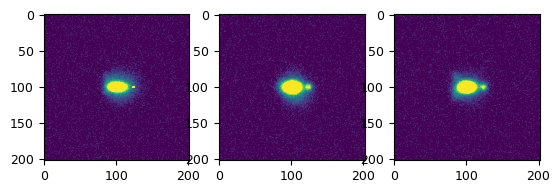

In [9]:
fig, (ax, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
print(np.mean(old_flux))
print(np.mean(new_flux))
print(np.mean(fid_flux))
ax.imshow(img_sdss_nopsf, vmin=0, vmax=1000)
ax2.imshow(img_sdss, vmin=0, vmax=1000)
ax3.imshow(img_sdss_OLD, vmin=0, vmax=1000)

In [ ]:
field_image, galaxy, r_pet, pristine = get_perfect_galaxy(mag_j0957, r_j0957,  fov_reff=40, pxscale=pxscale_sdss, q=q_j0957, return_image=True)
from photutils.aperture import CircularAperture, CircularAnnulus, EllipticalAperture


fig, (ax,ax2) = plt.subplots(nrows=2, ncols=1)

psf_vals = np.arange(0,3,0.5)

ap_size = 3

clump_properties = {
    'r' : [1.5],
    'theta' : [0],
    'flux' : [0.2],
    'sigma' : [0.1]
}



for psf in psf_vals:
    
    as_sq_vals_OLD = []
    as_sq_vals_new = []
    
    for i in range(20):
        # img_sdss_OLD = get_realistic_galaxy_OLD(field_image, galaxy, r_pet, mag_j0957, sky_mag=sky_sdss, n_clumps=20, 
        #                                 psf_fwhm=psf, clump_properties=clump_properties, rms_noise=True)

        img_sdss = get_realistic_galaxy(field_image, galaxy, r_pet, mag_j0957, sky_mag=sky_sdss, n_clumps=20, 
                                        psf_fwhm=psf, clump_properties=clump_properties, rms_noise=True)

        as_sq_OLD, x0_cas = get_asymmetry(img_sdss_OLD, ap_size=ap_size*r_pet, bg_size=50, a_type='squared', bg_corr='full', xtol=0.5, sky_type='annulus')
        as_sq_new, x0_sq = get_asymmetry(img_sdss, ap_size=ap_size*r_pet, bg_size=50, a_type='squared', bg_corr='full', xtol=0.5, sky_type='annulus')
        as_sq_vals_OLD.append(as_sq_OLD)
        as_sq_vals_new.append(as_sq_new)

    as_sq_vals_OLD = np.array(as_sq_vals_OLD)
    as_sq_vals_new = np.array(as_sq_vals_new)
    
    print(psf, np.mean(as_sq_vals_OLD))
    ax.scatter(psf, np.mean(as_sq_vals_OLD), color='k')#, label='Circular ap')
    ax2.scatter(psf, np.mean(as_sq_vals_new), color='k')#, label='Circular ap')

ax.set_ylim(0,1.99)
ax2.set_ylim(0,1.99)
ax2.set_xlabel('Seeing {FWHM in arcsec]')
ax.set_ylabel('A (with clumps convolved)')
ax2.set_ylabel('A (with image convolved)')
plt.show()

fig, (ax, ax2) = plt.subplots(nrows=1, ncols=2)

ap = CircularAperture( (img_sdss_OLD.shape[1]/2.0,img_sdss_OLD.shape[0]/2.0), r_pet*ap_size)
ax.imshow(img_sdss_OLD, vmin=0, vmax=1000)
ap.plot(ax)
ax2.imshow(img_sdss, vmin=0, vmax=1000)
ap.plot(ax2)